<a href="https://colab.research.google.com/github/sshin61/Sangmin/blob/main/horses_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import pandas as pd


In [4]:

def load_horses_orig(path, image_size):
    mask_path = path + 'masks/'
    image_path = path + 'images/'
    images = []
    masks = []
    test_images= []
    test_masks =[]
    for i in range(328):
        orig_im = cv2.imread(image_path + 'image-{}.png'.format(i))
        orig_im= cv2.cvtColor(orig_im, cv2.COLOR_RGB2BGR)

        low_im = cv2.resize(orig_im, dsize=(image_size, image_size))

        orig_mask = cv2.imread(mask_path + 'mask-{}.png'.format(i))
        low_mask = cv2.resize(orig_mask, dsize=(image_size, image_size))
        low_mask = cv2.cvtColor(low_mask, cv2.COLOR_RGB2GRAY)
        bin_mask = (low_mask > 0) + 0


        images.append(low_im)
        masks.append(bin_mask)


    xtest = np.reshape(np.array(images[250:]), (-1,image_size*image_size*3))
    ytest = np.reshape(np.array(masks[250:]), (-1, image_size * image_size))
    xdata = np.reshape(np.array(images[:200]), (-1,image_size*image_size*3))
    ydata = np.reshape(np.array(masks[:200]), (-1, image_size * image_size))
    yval =  np.reshape(np.array(masks[200:250]), (-1, image_size * image_size))
    xval = np.reshape(np.array(images[200:250]), (-1,image_size*image_size*3))


    return xdata, xval, xtest, ydata, yval, ytest


In [5]:
#change the path address according to your Google drive
path = '/content/drive/My Drive/aml/horses/'

#DO NOT CHANGE THE image_size
image_size = 32;
xdata, xval, xtest, ydata, yval, ytest = load_horses_orig(path, image_size)

error: OpenCV(4.12.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
#Change the range from 0..255 to 0..1
xdata = xdata/255.0
xtest = xtest/255.0
xval = xval/255.0

In [ ]:
#helper function to drawing horse and its mask
def draw(image, mask):
  fig, (ax1,ax2) = plt.subplots(1,2)
  ax1.axis('off')
  ax2.axis('off')
  ax1.imshow(np.reshape(image, (image_size,image_size,3)))
  ax2.imshow(np.reshape(mask, (image_size,image_size)), cmap=plt.cm.gray)
  plt.show()

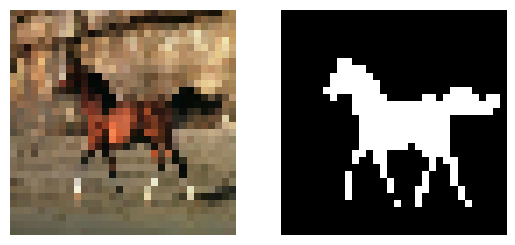

In [ ]:
draw(xdata[0], ydata[0])

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Assuming xdata and ydata are numpy arrays
xdata_tensor = torch.tensor(xdata, dtype=torch.float32)
ydata_tensor = torch.tensor(ydata, dtype=torch.float32)

# Create a TensorDataset
train_dataset = TensorDataset(xdata_tensor, ydata_tensor)

# Define batch size and shuffle the data
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


The intersection over union (IOU) is a metric for measuring the performance of image segmentation. The perfect segmentation receives IOU of one.

In [ ]:
# Do not change this cell
def iou(ytrue, yprediction):
    yp = yprediction
    yt = ytrue
    yp = yp > 0.5 + 0
    intersect = np.sum(np.minimum(yp, yt),1)
    union = np.sum(np.maximum(yp, yt),1)
    return np.average(intersect / (union+0.0))


In [ ]:
assert iou(ydata, ydata) == 1.0

We can use MLP or CNN model for image segmentation. Here the input is the image and the output is the segmentation mask.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class NeuralNet(nn.Module):

    def construct_CNN(self):
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),        # 32 → 16
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),        # 16 → 8
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # 8 → 16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),  # 16 → 32
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=1),  # 1채널 마스크 출력
            nn.Flatten()
        )

    def construct_MLP(self):
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(image_size * image_size * 3, 500),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(500, 20),
            nn.ReLU(),
            nn.Linear(20, image_size * image_size)
        )

    def __init__(self, network_type='MLP'):
        super(NeuralNet, self).__init__()


        if network_type == 'MLP':
            self.construct_MLP()
        else:
            self.construct_CNN()


        #Documents Me:
        # ....
        ## What are the other possible optimizers?
        # .....
        self.optimizer = optim.SGD(self.model.parameters(), lr=0.001)

    def forward(self, x, predict=True):
        logits = self.model(x)
        if predict:
            return torch.sigmoid(logits)
        return logits

    def get_loss(self, x, yt):
        # x = x.view(-1, 3, image_size, image_size)
        yt = yt.view(-1, image_size * image_size)
        ylogits = self.forward(x, predict=False)

        #Documents me:
        #...
        loss = F.binary_cross_entropy_with_logits(ylogits, yt, reduction='sum')
        return loss

    def train_step(self, xbatch, ybatch):
        self.optimizer.zero_grad()
        loss = self.get_loss(xbatch, ybatch)
        #Documents me:
        #...
        loss.backward()

        #Documents me
        self.optimizer.step()
        return loss.item()

    def predict(self, x):
        with torch.no_grad():
            y = self.forward(x, predict=True)
        return y.cpu().numpy()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = NeuralNet('CNN')
# model = NeuralNet('MLP')
model.to(device)

train_iou = []
val_iou = []
test_iou = []
epoch = 1;
best_val_iou = -1;
best_test_iou = -1

#You can save the best model on your Google drive
best_model_path = "best_model.pth"

Epoch 99, Loss: 6.95e+04, IOU - Train: 0.513 Test: 0.511


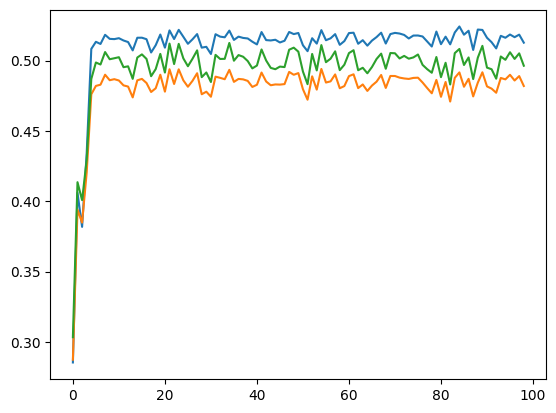

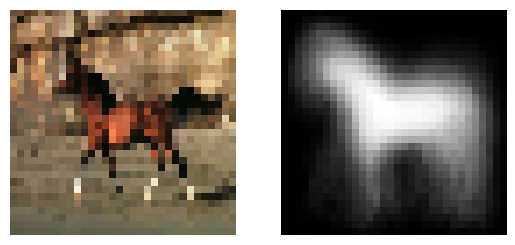

In [ ]:
# You can reduce the number of epochs if you want
max_epoch = 1000

xdata_tensor = torch.tensor(xdata, dtype=torch.float32).view(-1, image_size, image_size, 3).permute(0,3,1,2).to(device)
xval_tensor = torch.tensor(xval, dtype=torch.float32).view(-1, image_size, image_size, 3).permute(0,3,1,2).to(device)
xtest_tensor = torch.tensor(xtest, dtype=torch.float32).view(-1, image_size, image_size, 3).permute(0,3,1,2).to(device)

while epoch < max_epoch:
  loss = 0.0
  for batch in train_loader:
    xbatch, ybatch = batch  # Unpack the batch into inputs and targets

    # Ensure the data is of type float32
    xbatch = xbatch.float().to(device)
    ybatch = ybatch.float().to(device)

    # # Reshape xbatch if needed (assuming xbatch is in shape (batch_size, 3, image_size, image_size))
    xbatch = xbatch.view(-1, image_size, image_size, 3).permute(0,3,1,2)

    # Run the training step and accumulate loss
    loss += model.train_step(xbatch, ybatch)


  ydata_pred = model.predict(xdata_tensor)
  yval_pred = model.predict(xval_tensor)
  ytest_pred = model.predict(xtest_tensor)

  train_iou.append(iou(ydata,ydata_pred))
  val_iou.append(iou(yval,yval_pred))
  test_iou.append(iou(ytest,ytest_pred))

  if val_iou[-1] > best_val_iou:
    best_test_iou = test_iou[-1]
    best_val_iou = val_iou[-1]

    #This saves the best model parameters; you can use this weights for evaluatoions
    #You can also save the weights on your Google drive and continue the training by initializing the weights from the previous best model
    torch.save(model.state_dict(), best_model_path)

  display.clear_output(wait=False)

  print("Epoch {}, Loss: {:0.3}, IOU - Train: {:0.3} Test: {:0.3}".format( epoch, loss, train_iou[-1], best_test_iou))

  fig, ax = plt.subplots(1,1)
  pd.Series(train_iou).plot(ax=ax)
  pd.Series(val_iou).plot(ax=ax)
  pd.Series(test_iou).plot(ax=ax)
  fig.canvas.draw()

  draw(xdata[0], ydata_pred[0])

  epoch += 1


In [ ]:
#Do not change the cell
def evaluate(model, xset, yset):
    ypred = model.predict(xset);
    return iou(yset, ypred)

In [ ]:
#Run this cell! Do not change the cell
model.load_state_dict(torch.load(best_model_path))
print("Best test score: " + str(evaluate(model, xtest_tensor, ytest)))


Best test score: 0.5109764042144521


In [ ]:
#Run this cell and the following cells
ypred_test = model.predict(xtest_tensor)

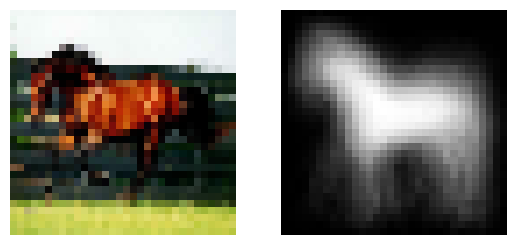

In [ ]:
#Run this cell and the following cells
#Draw couple of examples
draw(xtest[4], ypred_test[4])

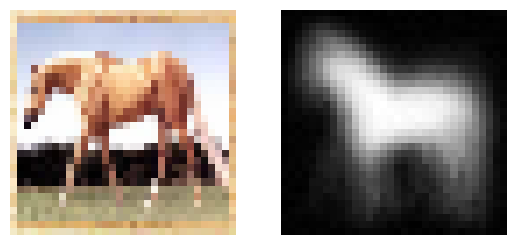

In [ ]:
#Run this cell and the following cells
draw(xtest[10], ypred_test[10])

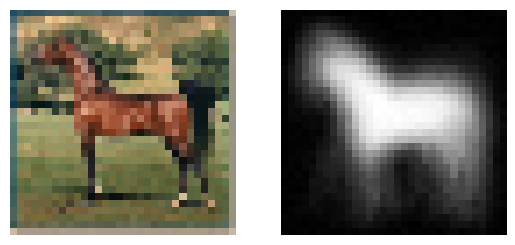

In [ ]:
#Run this cell and the following cells
draw(xtest[20], ypred_test[20])